# ![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)
---
# Experiment 3 — Frontier LLMs via OpenRouter API
### Zero-Shot Dialogue Summarization with GPT, Claude, Gemini, and More
---

This experiment completes our three-part investigation by testing **frontier large language models** on dialogue summarization—no training required, just inference via API.

**The Question**

Experiments 1 and 2 showed what's possible with fine-tuned local models: the custom DistilBERT→DistilGPT2 architecture reached ROUGE-L 30.29, while purpose-built BART achieved 42.13. But what happens if we skip training entirely and just *ask* the most capable models in the world to summarize conversations?

This is the approach many teams try first in practice. Before investing in custom fine-tuning infrastructure, it's natural to wonder: *"Can we just prompt GPT/Claude/Gemini and call it a day?"*

**The Models**

We evaluate five frontier models via the OpenRouter API, selected to span the major providers and price points:

| Model | Provider | Parameters | Context | Input Cost | Output Cost |
|-------|----------|------------|---------|------------|-------------|
| **GPT-5 Mini** | OpenAI | Compact | 400K | $0.25/M | $2.00/M |
| **Gemini 2.5 Flash** | Google | Workhorse | 1.05M | $0.30/M | $2.50/M |
| **Claude 4.5 Haiku** | Anthropic | Fast | 200K | $1.00/M | $5.00/M |
| **Qwen 2.5 72B** | Alibaba | 72B active | 33K | $0.07/M | $0.26/M |
| **Kimi K2** | Moonshot AI | 1T total (32B active) | 262K | $0.39/M | $1.90/M |

This selection includes:
- **The "big three" frontier labs:** OpenAI, Anthropic, and Google
- **Two strong Chinese models:** Qwen (open-weight) and Kimi K2 (trillion-parameter MoE)
- **A 70× cost spread:** From Qwen at $0.07/M input to Claude at $1.00/M input

The diversity lets us explore whether price correlates with summarization quality.

**Why This Matters**

Zero-shot API models offer compelling advantages:
- **No training required** — deploy immediately
- **No GPU infrastructure** — runs anywhere with internet
- **Always up-to-date** — models improve without your intervention
- **Massive scale** — billions of parameters, trillions of training tokens

But they also have costs:
- **Per-query pricing** — every summary costs money
- **Latency variability** — depends on provider load and geography
- **Privacy concerns** — data leaves your infrastructure
- **Less control** — you can't fine-tune for your domain

This experiment measures whether the "just use GPT" approach actually works for dialogue summarization, and how it compares to the fine-tuned models from Experiments 1 and 2.

**What This Notebook Covers**

1. Configuration and API client setup
2. Loading the SAMSum test set (same 819 examples as Experiments 1 & 2)
3. Zero-shot prompt construction
4. Running API calls with caching and retry logic
5. ROUGE evaluation on the held-out test set
6. Latency analysis and qualitative examples
7. Initial comparison to fine-tuned baselines

The detailed cross-experiment analysis will follow in the final comparison notebook.

## 1. Environment Setup

In [19]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import random
import numpy as np
import pandas as pd
import time
import requests
import json
import hashlib
from pathlib import Path
import sys
import warnings

# Mute common warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Project root for imports
PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print(f"Project root: {PROJECT_ROOT}")
print(f"Random seed: {SEED}")

Project root: /home/timnevits/projects/flatiron-language-models-for-ai
Random seed: 42


## 2. Configuration

All hyperparameters and paths in one place for easy modification.

**Important:** 
- Set `RUN_API_CALLS` to `False` to load cached results instead of making new API calls
- Set `EVALUATION_MODE` to `"full"` for final results on the entire test set

In [ ]:
# =============================================================================
# API CALL FLAGS
# =============================================================================

# Master switch: Set False to load ALL results from cache (no API calls).
# Useful for re-running analysis without incurring API costs or waiting for
# network requests. Results are cached per-model in CACHE_DIR.
RUN_API_CALLS = True

# Per-model control: Set individual models to False to skip them.
# Only matters if RUN_API_CALLS = True. Useful for debugging a single model
# or re-running only models that failed in a previous run.
MODELS_TO_RUN = {
    "gpt5_mini":                True,
    "gemini_25_flash":          True,
    "claude_45_haiku":          True,
    "qwen25_72b":               True,
    "kimi_k2":                  True,
}

# =============================================================================
# EVALUATION MODE
# =============================================================================

# "test": Use a small sample (fast, cheap) for development and debugging.
#         Helps verify the pipeline works before committing to full API costs.
# "full": Use entire test set (819 examples) for final results.
#         Required for fair comparison with Experiments 1 & 2, which also
#         evaluated on the complete SAMSum test split.
EVALUATION_MODE = "full"  # Change to "full" for final evaluation

# How many samples to use in "test" mode (ignored in "full" mode).
# 10 samples is enough to verify API connectivity, prompt formatting, and
# basic output quality without significant cost or time investment.
TEST_MODE_SAMPLES = 10

# =============================================================================
# GENERATION PARAMETERS
# (Aligned with Experiments 1 & 2 for fair comparison)
# =============================================================================

# Max tokens for model responses. Set to 64 to match the max_target_len used
# in Experiments 1 & 2. SAMSum summaries average ~20 words (~30 tokens), so
# 64 provides headroom while preventing runaway generation. Note that API
# models may produce shorter outputs if they finish the summary naturally.
MAX_TARGET_LEN = 64

# Low temperature for consistent, deterministic outputs. Higher values (0.7+)
# would produce more varied summaries, but we want reproducible results that
# can be fairly compared across runs. 0.2 keeps outputs focused while allowing
# minor variation to avoid pure greedy decoding artifacts.
TEMPERATURE = 0.2

# Documented for reference: Experiments 1 & 2 used beam search with 4 beams.
# API models use different decoding strategies (typically nucleus sampling),
# so this parameter doesn't apply directly, but we note it for transparency.
NUM_BEAMS = 4

# =============================================================================
# MODEL DEFINITIONS
# =============================================================================
# We evaluate five frontier models spanning major providers and price points.
#
# Selection criteria:
# - Major frontier labs: OpenAI, Google, Anthropic (the "big three")
# - Open-source alternatives: Qwen (Alibaba), Kimi K2 (Moonshot AI)
# - Fast/efficient variants: Mini, Flash, Haiku (not full-size flagships)
# - Price diversity: From $0.07/M (Qwen) to $1.00/M (Claude) input tokens
#
# Pricing as of December 2025 (via OpenRouter):
# - GPT-5 Mini:        $0.25/M input, $2.00/M output (400K context)
# - Gemini 2.5 Flash:  $0.30/M input, $2.50/M output (1.05M context)
# - Claude 4.5 Haiku:  $1.00/M input, $5.00/M output (200K context)
# - Qwen 2.5 72B:      $0.07/M input, $0.26/M output (33K context)
# - Kimi K2:           $0.39/M input, $1.90/M output (262K context)

OPENROUTER_MODELS = {
    # OpenAI GPT-5 Mini: Compact version of GPT-5 for lighter reasoning tasks.
    # Successor to o4-mini. Good balance of capability and cost.
    # 400K context, $0.25/M input, $2.00/M output
    "gpt5_mini":       "openai/gpt-5-mini",

    # Google Gemini 2.5 Flash: Speed-optimized workhorse model with built-in
    # "thinking" capabilities. Designed for advanced reasoning and coding.
    # 1.05M context (largest), $0.30/M input, $2.50/M output
    "gemini_25_flash": "google/gemini-2.5-flash",

    # Anthropic Claude 4.5 Haiku: Fastest Claude model, near-frontier quality
    # at lower latency. Extended thinking support, strong at coding (73% SWE-bench).
    # 200K context, $1.00/M input (most expensive), $5.00/M output
    "claude_45_haiku": "anthropic/claude-haiku-4.5",

    # Qwen 2.5 72B Instruct: Alibaba's open-weight model. 72B parameters,
    # strong multilingual support (29 languages), improved coding/math.
    # 33K context (smallest), $0.07/M input (cheapest), $0.26/M output
    "qwen25_72b":      "qwen/qwen-2.5-72b-instruct",

    # Moonshot Kimi K2: 1 trillion total parameters (32B active per forward).
    # MoE architecture, optimized for agentic/tool-use tasks.
    # 262K context, $0.39/M input, $1.90/M output
    "kimi_k2":         "moonshotai/kimi-k2-0905",
}

# =============================================================================
# PATHS
# =============================================================================
# All artifacts for this experiment live under models/api-frontier.
# Separating from Experiments 1 & 2 keeps results organized and allows
# independent re-runs without overwriting fine-tuned model outputs.
OUTPUT_DIR = PROJECT_ROOT / "models" / "api-frontier"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Cache directory for API responses. Each model's predictions are saved
# separately, allowing partial re-runs if some models fail or need updates.
# This is critical for cost control—we don't want to re-run successful models.
CACHE_DIR = OUTPUT_DIR / "cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Test results path matches the format from Experiments 1 & 2 for easy
# consolidation in the final comparison notebook.
TEST_RESULTS_PATH = OUTPUT_DIR / "test_results.csv"

# Individual model predictions saved here for qualitative analysis and
# debugging. Format matches Experiments 1 & 2 (dialogue, summary, prediction).
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
PREDICTIONS_DIR.mkdir(parents=True, exist_ok=True)

print("Configuration loaded.")
print(f"  Evaluation mode: {EVALUATION_MODE}")
if EVALUATION_MODE == "test":
    print(f"  Sample size: {TEST_MODE_SAMPLES} examples")
else:
    print(f"  Sample size: FULL test set")
print(f"  Max target length: {MAX_TARGET_LEN} (aligned with Experiments 1 & 2)")
print(f"  Models configured: {len(OPENROUTER_MODELS)}")
print(f"  Output directory: {OUTPUT_DIR}")


Configuration loaded.
  Evaluation mode: full
  Sample size: FULL test set
  Max target length: 64 (aligned with Experiments 1 & 2)
  Models configured: 5
  Output directory: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier


### Model Selection Rationale

We chose these five models to answer specific questions:

1. **Do the "big three" labs (OpenAI, Google, Anthropic) outperform each other?**
   - GPT-5 Mini, Gemini 2.5 Flash, and Claude 4.5 Haiku represent each lab's fast/efficient offering

2. **Can open-weight models compete with proprietary APIs?**
   - Qwen 2.5 72B is fully open-weight and 14× cheaper than Claude
   - Kimi K2 is a trillion-parameter MoE from an emerging Chinese lab

3. **Does price predict quality?**
   - Our price range spans from $0.07/M (Qwen) to $1.00/M (Claude)—a 14× spread

4. **How do context windows and architecture choices affect summarization?**
   - Context ranges from 33K (Qwen) to 1.05M (Gemini)
   - Kimi K2 uses MoE (32B active of 1T total), others are dense

All models are accessed through OpenRouter for unified API handling, consistent rate limiting, and comparable latency measurement.

## 3. OpenRouter API Client

All API interaction code is defined here for transparency and reproducibility.

**Design choices:**
- **Retry logic:** Up to 3 attempts with exponential backoff for transient failures
- **Timeout handling:** 10s connect, 60s read to handle slow model responses
- **Error tracking:** Failed calls return a unique prefix (`[__OPENROUTER_ERROR__:`) for filtering during evaluation
- **Rate limiting:** Small delay between requests to avoid throttling
- **Reasoning config:** Models with chain-of-thought capabilities use "minimal" effort to reduce latency

In [21]:
# =============================================================================
# OPENROUTER API CLIENT
# =============================================================================

# Load API key from environment variable
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")

if OPENROUTER_API_KEY is None:
    print("⚠️  WARNING: OPENROUTER_API_KEY environment variable not set.")
    print("   Set it with: export OPENROUTER_API_KEY='your-key-here'")
    print("   API calls will fail until this is set.")
else:
    print(f"✓ OpenRouter API key loaded (ends with ...{OPENROUTER_API_KEY[-4:]})")

# API configuration
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1/chat/completions"
REQUEST_TIMEOUT = (10, 60)  # (connect_timeout, read_timeout) in seconds
MAX_RETRIES = 3

# Unique error prefix for identifying API failures in results
ERROR_PREFIX = "[__OPENROUTER_ERROR__:"


def _get_api_headers():
    """Get headers for API requests. Raises if key not set."""
    if OPENROUTER_API_KEY is None:
        raise RuntimeError(
            "OPENROUTER_API_KEY environment variable not set.\n"
            "Set it with: export OPENROUTER_API_KEY='your-key-here'"
        )
    return {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "Content-Type": "application/json",
    }


def _get_reasoning_config(model: str) -> dict:
    """
    Return reasoning config for models that support it.
    Uses "minimal" effort to reduce latency/cost.
    """
    base = model.split("/")[-1].lower()
    
    # Models that support reasoning
    reasoning_prefixes = ("gpt-5-mini",)
    
    for prefix in reasoning_prefixes:
        if base.startswith(prefix):
            return {"effort": "minimal", "exclude": True}
    
    return {"effort": "none", "exclude": True}


def call_openrouter_api(
    model: str,
    prompt: str,
    max_tokens: int = 64,
    temperature: float = 0.2,
):
    """
    Call an LLM via OpenRouter API.
    
    Parameters
    ----------
    model : str
        OpenRouter model identifier (e.g., "openai/gpt-5-mini")
    prompt : str
        The user prompt to send
    max_tokens : int
        Maximum tokens in response
    temperature : float
        Sampling temperature (lower = more deterministic)
    
    Returns
    -------
    tuple
        (response_text, latency_seconds)
        On error, response_text starts with ERROR_PREFIX
    """
    headers = _get_api_headers()
    
    payload = {
        "model": model,
        "max_tokens": max_tokens,
        "temperature": temperature,
        "messages": [
            {
                "role": "system",
                "content": "You summarize chat conversations accurately and concisely."
            },
            {
                "role": "user",
                "content": prompt
            },
        ],
    }
    
    # Add reasoning config if applicable
    reasoning_config = _get_reasoning_config(model)
    if reasoning_config:
        payload["reasoning"] = reasoning_config
    
    last_error = None
    
    for attempt in range(1, MAX_RETRIES + 1):
        t0 = time.time()
        
        try:
            response = requests.post(
                OPENROUTER_BASE_URL,
                headers=headers,
                json=payload,
                timeout=REQUEST_TIMEOUT,
            )
            t1 = time.time()
            
            # Small delay for rate limiting
            time.sleep(0.05)
            
            # Parse JSON response
            try:
                data = response.json()
            except Exception as json_err:
                raise RuntimeError(f"Failed to parse JSON: {json_err}")
            
            # Check HTTP status
            if response.status_code != 200:
                error_msg = data.get("error", {}).get("message", response.text) if data else response.text
                raise RuntimeError(f"API error {response.status_code}: {error_msg}")
            
            # Extract response text
            try:
                if not data:
                    raise ValueError("Empty response")
                
                choices = data.get("choices")
                if not choices or len(choices) == 0:
                    raise ValueError(f"No choices in response: {data}")
                
                message = choices[0].get("message")
                if not message:
                    raise ValueError(f"No message in choice: {choices[0]}")
                
                text = message.get("content", "")
                
                if not isinstance(text, str):
                    text = str(text) if text is not None else ""
                
                if text.strip() == "":
                    text = f"{ERROR_PREFIX} EMPTY_RESPONSE]"
                    
            except (KeyError, IndexError, TypeError, ValueError) as extract_err:
                text = f"{ERROR_PREFIX} MALFORMED_RESPONSE: {extract_err}]"
            
            latency = t1 - t0
            return text, latency
            
        except (requests.exceptions.Timeout, requests.exceptions.ConnectionError) as e:
            last_error = e
            if attempt < MAX_RETRIES:
                # Exponential backoff
                time.sleep(0.5 * (2 ** (attempt - 1)))
            else:
                break
                
        except RuntimeError:
            raise
    
    # All retries failed
    return f"{ERROR_PREFIX} Request failed after {MAX_RETRIES} attempts: {last_error}]", float('nan')


print("\nAPI client functions defined.")

✓ OpenRouter API key loaded (ends with ...5990)

API client functions defined.


## 4. Load SAMSum Test Data

In [22]:
from src.data.load_data import load_samsum

train_df, val_df, test_df = load_samsum()

print(f"Dataset sizes:")
print(f"  Train:      {len(train_df):,} examples")
print(f"  Validation: {len(val_df):,} examples")
print(f"  Test:       {len(test_df):,} examples")

Dataset sizes:
  Train:      14,731 examples
  Validation: 818 examples
  Test:       819 examples


In [23]:
# Quick peek at the data
print("Sample dialogue:")
print("-" * 40)
print(test_df.iloc[0]["dialogue"][:300], "...")
print()
print("Sample summary:")
print("-" * 40)
print(test_df.iloc[0]["summary"])

Sample dialogue:
----------------------------------------
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
H ...

Sample summary:
----------------------------------------
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


## 5. Prepare Evaluation Sample

We use a consistent sample for reproducibility. The sample is cached to ensure
the same examples are used across runs.

In [24]:
def get_evaluation_sample(test_df, n_samples, seed, cache_dir):
    """
    Get evaluation sample with caching for reproducibility.
    
    Saves metadata to ensure we're using consistent samples across runs.
    """
    sample_path = cache_dir / "evaluation_sample.csv"
    metadata_path = cache_dir / "evaluation_sample_metadata.json"
    
    # Create fingerprint of source data
    source_len = len(test_df)
    dialogue_lengths = test_df['dialogue'].str.len().tolist()
    
    fingerprint_data = {
        "length": source_len,
        "dialogue_length_sum": sum(dialogue_lengths),
        "first_dialogue": test_df['dialogue'].iloc[0][:200] if source_len > 0 else "",
        "last_dialogue": test_df['dialogue'].iloc[-1][:200] if source_len > 0 else "",
    }
    
    data_fingerprint = hashlib.md5(
        json.dumps(fingerprint_data, sort_keys=True).encode()
    ).hexdigest()[:16]
    
    # Check for valid cached sample
    if sample_path.exists() and metadata_path.exists():
        try:
            with open(metadata_path, 'r') as f:
                saved_meta = json.load(f)
            
            if (saved_meta.get('n_samples') == n_samples and
                saved_meta.get('seed') == seed and
                saved_meta.get('data_hash') == data_fingerprint):
                
                existing_sample = pd.read_csv(sample_path)
                
                if len(existing_sample) == n_samples:
                    print(f"✓ Loaded cached sample of {len(existing_sample)} examples")
                    print(f"  (seed={seed}, hash={data_fingerprint[:8]}...)")
                    return existing_sample
                    
        except (json.JSONDecodeError, KeyError):
            pass
    
    # Create new sample
    if n_samples >= len(test_df):
        sample = test_df.copy().reset_index(drop=True)
        print(f"Using full test set: {len(sample)} examples")
    else:
        sample = test_df.sample(n=n_samples, random_state=seed).reset_index(drop=True)
        print(f"Created sample of {len(sample)} examples (seed={seed})")
    
    # Save sample and metadata
    sample.to_csv(sample_path, index=False)
    
    metadata = {
        'n_samples': n_samples,
        'seed': seed,
        'data_hash': data_fingerprint,
        'source_len': source_len,
        'created_at': pd.Timestamp.now().isoformat(),
    }
    
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved to cache: {sample_path.name}")
    
    return sample


# Determine sample size based on evaluation mode
if EVALUATION_MODE == "full":
    N_SAMPLES = len(test_df)
    print(f"\n⚡ FULL EVALUATION MODE: Using ALL {N_SAMPLES} test examples")
    print(f"   ⚠️  This will take a while and cost more in API calls!\n")
else:
    N_SAMPLES = TEST_MODE_SAMPLES
    print(f"\n🧪 TEST MODE: Using {N_SAMPLES} examples (for development)")
    print(f"   Change EVALUATION_MODE to 'full' for final results.\n")

# Get the evaluation sample
eval_df = get_evaluation_sample(test_df, N_SAMPLES, SEED, CACHE_DIR)

print(f"\nEvaluation sample: {len(eval_df)} examples")
eval_df.head()


⚡ FULL EVALUATION MODE: Using ALL 819 test examples
   ⚠️  This will take a while and cost more in API calls!

✓ Loaded cached sample of 819 examples
  (seed=42, hash=f67f1de0...)

Evaluation sample: 819 examples


,id,dialogue,summary
0,13862856,"Hannah: Hey, do you have Betty's number?\nAman...",Hannah needs Betty's number but Amanda doesn't...
1,13729565,Eric: MACHINE!\nRob: That's so gr8!\nEric: I k...,Eric and Rob are going to watch a stand-up on ...
2,13680171,"Lenny: Babe, can you help me with something?\n...",Lenny can't decide which trousers to buy. Bob ...
3,13729438,"Will: hey babe, what do you want for dinner to...",Emma will be home soon and she will let Will k...
4,13828600,"Ollie: Hi , are you in Warsaw\nJane: yes, just...",Jane is in Warsaw. Ollie and Jane has a party....


## 6. Prompt Construction

We use a consistent zero-shot prompt across all models. The prompt is designed to:

- **Match SAMSum style:** Request 1–2 sentences, 15–30 words
- **Focus on outcomes:** Emphasize decisions, requests, and action items
- **Reduce hallucination:** Explicitly instruct not to add unsupported details
- **Stay simple:** No few-shot examples, no complex formatting

This keeps the comparison fair across models and isolates their raw zero-shot capabilities.

In [25]:
def build_summarization_prompt(dialogue: str) -> str:
    """
    Build a zero-shot summarization prompt for frontier LLMs.
    
    The prompt is designed to produce concise summaries similar
    to the SAMSum reference summaries (typically 15-30 words).
    """
    return (
        "Summarize the following conversation in 1-2 sentences. "
        "Keep it brief — aim for 15-30 words. "
        "Focus on the main point, decisions, requests, or outcomes. "
        "Ignore small talk and do not add details that aren't supported by the text.\n\n"
        "DIALOGUE:\n"
        "-----\n"
        f"{dialogue}\n"
        "-----\n\n"
        "SUMMARY:"
    )


# Test the prompt
print("Example prompt:")
print("=" * 60)
example_prompt = build_summarization_prompt(eval_df['dialogue'].iloc[0])
print(example_prompt[:500] + "..." if len(example_prompt) > 500 else example_prompt)

Example prompt:
Summarize the following conversation in 1-2 sentences. Keep it brief — aim for 15-30 words. Focus on the main point, decisions, requests, or outcomes. Ignore small talk and do not add details that aren't supported by the text.

DIALOGUE:
-----
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be s...


## 7. Run API Calls

Generate summaries for each model. Results are cached per-model for efficiency.

**Caching strategy:**
- Each model's results are saved to `{model_label}_predictions.csv` in the cache directory
- If `RUN_API_CALLS=True`, we re-run even if cache exists (for fresh results)
- If `RUN_API_CALLS=False`, we load from cache only
- This allows mixing cached and fresh results during development

In [26]:
from tqdm.auto import tqdm


def get_model_cache_path(model_label: str) -> Path:
    """Get the cache path for a model's results."""
    return CACHE_DIR / f"{model_label}_predictions.csv"


def load_cached_predictions(model_label: str) -> pd.DataFrame | None:
    """Load cached predictions for a model if they exist."""
    path = get_model_cache_path(model_label)
    if path.exists():
        return pd.read_csv(path)
    return None


def run_model_predictions(model_label: str, model_id: str, eval_df: pd.DataFrame) -> pd.DataFrame:
    """
    Run API calls for a single model and return results DataFrame.
    
    Returns DataFrame with columns:
    - dialogue
    - reference_summary (human)
    - model_summary (prediction)
    - latency_seconds
    """
    rows = []
    
    for idx, row in tqdm(eval_df.iterrows(), total=len(eval_df), desc=model_label):
        dialogue = row["dialogue"]
        reference = row["summary"]
        prompt = build_summarization_prompt(dialogue)
        
        try:
            prediction, latency = call_openrouter_api(
                model=model_id,
                prompt=prompt,
                max_tokens=MAX_TARGET_LEN,
                temperature=TEMPERATURE,
            )
        except Exception as e:
            prediction = f"{ERROR_PREFIX} {e}]"
            latency = np.nan
        
        rows.append({
            "dialogue": dialogue,
            "reference_summary": reference,
            "model_summary": prediction,
            "latency_seconds": latency,
        })
    
    return pd.DataFrame(rows)


print("Helper functions defined.")

Helper functions defined.


In [27]:
print("\n" + "=" * 70)
print("RUNNING MODEL EVALUATIONS")
print("=" * 70)

results_by_model = {}
models_run = []
models_loaded = []
models_skipped = []

for label, model_id in OPENROUTER_MODELS.items():
    cache_path = get_model_cache_path(label)
    
    # Check if we should run this model
    should_run = RUN_API_CALLS and MODELS_TO_RUN.get(label, True)
    
    if should_run:
        if cache_path.exists():
            print(f"\n{label}: Cache exists, re-running (RUN_API_CALLS=True)")
        else:
            print(f"\n{label}: Running API calls...")
        
        # Run predictions
        df_results = run_model_predictions(label, model_id, eval_df)
        
        # Cache results
        df_results.to_csv(cache_path, index=False)
        print(f"  ✓ Saved {len(df_results)} results to {cache_path.name}")
        
        results_by_model[label] = df_results
        models_run.append(label)
        
    else:
        # Try to load from cache
        cached = load_cached_predictions(label)
        
        if cached is not None:
            results_by_model[label] = cached
            models_loaded.append(label)
            print(f"{label}: Loaded {len(cached)} cached results")
        else:
            models_skipped.append(label)
            print(f"{label}: No cache found (skipping)")

# Summary
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"  Models run (API calls):  {len(models_run)} - {models_run}")
print(f"  Models loaded (cache):   {len(models_loaded)} - {models_loaded}")
print(f"  Models skipped:          {len(models_skipped)} - {models_skipped}")
print(f"  Total models available:  {len(results_by_model)}")


RUNNING MODEL EVALUATIONS

gpt5_mini: Cache exists, re-running (RUN_API_CALLS=True)


gpt5_mini: 100%|██████████| 819/819 [17:05<00:00,  1.25s/it]


  ✓ Saved 819 results to gpt5_mini_predictions.csv

gemini_25_flash: Cache exists, re-running (RUN_API_CALLS=True)


gemini_25_flash: 100%|██████████| 819/819 [09:32<00:00,  1.43it/s]


  ✓ Saved 819 results to gemini_25_flash_predictions.csv

claude_45_haiku: Cache exists, re-running (RUN_API_CALLS=True)


claude_45_haiku: 100%|██████████| 819/819 [24:14<00:00,  1.78s/it]


  ✓ Saved 819 results to claude_45_haiku_predictions.csv

qwen25_72b: Cache exists, re-running (RUN_API_CALLS=True)


qwen25_72b: 100%|██████████| 819/819 [40:55<00:00,  3.00s/it]  


  ✓ Saved 819 results to qwen25_72b_predictions.csv

kimi_k2: Cache exists, re-running (RUN_API_CALLS=True)


kimi_k2: 100%|██████████| 819/819 [30:43<00:00,  2.25s/it] 

  ✓ Saved 819 results to kimi_k2_predictions.csv

SUMMARY
  Models run (API calls):  5 - ['gpt5_mini', 'gemini_25_flash', 'claude_45_haiku', 'qwen25_72b', 'kimi_k2']
  Models loaded (cache):   0 - []
  Models skipped:          0 - []
  Total models available:  5


## 8. ROUGE Evaluation

Compute ROUGE scores using the same methodology as Experiments 1 and 2.

**Important:** We use identical settings (`use_stemmer=True`) and the same test split to ensure scores are directly comparable. Any errors (API failures, malformed responses) are filtered before computing ROUGE to avoid penalizing models for infrastructure issues.

In [28]:
import evaluate

# Load ROUGE metric
rouge_metric = evaluate.load("rouge")


def compute_rouge(predictions: list, references: list) -> dict:
    """
    Compute ROUGE scores for predictions vs references.
    
    Uses the same configuration as Experiments 1 and 2 for consistency.
    
    Returns dict with rouge1, rouge2, rougeL, rougeLsum as percentages (0-100).
    """
    # Clean inputs
    def clean_text(text):
        if text is None or (isinstance(text, float) and pd.isna(text)):
            return ""
        return str(text).strip()
    
    predictions = [clean_text(p) for p in predictions]
    references = [clean_text(r) for r in references]
    
    result = rouge_metric.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True,  # Same as experiments 1 & 2
    )
    
    # Convert to percentages for consistency with Experiments 1 & 2
    result = {k: round(v * 100, 2) for k, v in result.items()}
    
    return result


print("ROUGE evaluation function defined.")

ROUGE evaluation function defined.


In [29]:
print("\n" + "=" * 70)
print("ROUGE EVALUATION")
print("=" * 70)

rouge_scores = {}
sample_counts = {}

for label, df in results_by_model.items():
    # Filter out API errors
    valid_mask = ~df["model_summary"].str.startswith(ERROR_PREFIX)
    valid_df = df[valid_mask]
    
    if len(valid_df) == 0:
        print(f"❌ {label}: No valid responses (all failed)")
        continue
    
    error_count = len(df) - len(valid_df)
    if error_count > 0:
        error_pct = error_count / len(df) * 100
        print(f"⚠️  {label}: {error_count} errors ({error_pct:.1f}%), evaluating {len(valid_df)} responses")
    
    # Compute ROUGE (returns percentages)
    scores = compute_rouge(
        predictions=valid_df["model_summary"].tolist(),
        references=valid_df["reference_summary"].tolist(),
    )
    
    rouge_scores[label] = scores
    sample_counts[label] = len(valid_df)

# Create summary DataFrame
if rouge_scores:
    rouge_df = pd.DataFrame.from_dict(rouge_scores, orient="index")
    rouge_df.index.name = "model"
    rouge_df["n_samples"] = pd.Series(sample_counts)
    rouge_df = rouge_df.sort_values(by="rougeL", ascending=False)
    
    # Check for comparability
    min_samples = rouge_df["n_samples"].min()
    max_samples = rouge_df["n_samples"].max()
    
    if min_samples != max_samples:
        print("\n" + "=" * 60)
        print("⚠️  COMPARABILITY WARNING")
        print("=" * 60)
        print(f"Models evaluated on different sample sizes ({min_samples} to {max_samples})")
        print("ROUGE scores may not be directly comparable.")
        print("=" * 60)
    
    print("\nROUGE Scores (sorted by ROUGE-L):")
    display(rouge_df)
    
else:
    rouge_df = None
    print("No ROUGE scores to display.")


ROUGE EVALUATION
⚠️  qwen25_72b: 30 errors (3.7%), evaluating 789 responses

⚠️  COMPARABILITY WARNING
Models evaluated on different sample sizes (789 to 819)
ROUGE scores may not be directly comparable.

ROUGE Scores (sorted by ROUGE-L):


,rouge1,rouge2,rougeL,rougeLsum,n_samples
model,,,,,
gemini_25_flash,44.60,17.85,35.49,35.51,819
qwen25_72b,44.15,17.31,35.17,35.19,789
claude_45_haiku,43.62,16.55,34.58,34.59,819
kimi_k2,41.42,13.22,32.36,32.38,819
gpt5_mini,41.56,14.34,32.15,32.17,819


## 9. Latency Analysis

Latency is measured end-to-end from request initiation to response parsing. This includes:
- Network round-trip time
- Model inference time
- Any provider-side queuing

**Note:** Latency varies by time of day, provider load, and geographic location. These measurements represent a single run and may not generalize to all conditions.

In [30]:
print("\n" + "=" * 70)
print("LATENCY ANALYSIS")
print("=" * 70)

latency_stats = {}

for label, df in results_by_model.items():
    latencies = df["latency_seconds"].replace([np.inf, -np.inf], np.nan).dropna()
    
    if len(latencies) == 0:
        continue
    
    stats = latencies.describe(percentiles=[0.5, 0.9, 0.95])
    latency_stats[label] = stats

if latency_stats:
    latency_df = pd.DataFrame(latency_stats).T
    latency_df.index.name = "model"
    
    # Rename columns for clarity
    latency_df = latency_df.rename(columns={
        "50%": "p50",
        "90%": "p90",
        "95%": "p95",
    })
    
    # Sort by mean latency
    latency_df = latency_df.sort_values(by="mean", ascending=True)
    
    print("\nLatency Statistics (seconds, sorted by mean):")
    display(latency_df[["count", "mean", "std", "min", "p50", "p90", "p95", "max"]])
    
else:
    latency_df = None
    print("No latency data to display.")


LATENCY ANALYSIS

Latency Statistics (seconds, sorted by mean):


,count,mean,std,min,p50,p90,p95,max
model,,,,,,,,
gemini_25_flash,819.0,0.647544,0.171487,0.455604,0.616910,0.752706,0.808989,2.646552
gpt5_mini,819.0,1.199934,0.334696,0.709175,1.132372,1.491899,1.642712,5.808657
claude_45_haiku,819.0,1.723604,0.726473,1.003187,1.625675,2.172446,2.405935,11.445165
kimi_k2,819.0,2.198808,2.043115,0.309427,1.179483,5.025968,6.343143,11.416361
qwen25_72b,819.0,2.946368,2.351451,0.427573,2.165694,5.675332,8.087161,14.889447


## 10. Visualizations

Saved figure to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/rouge_latency_comparison.png


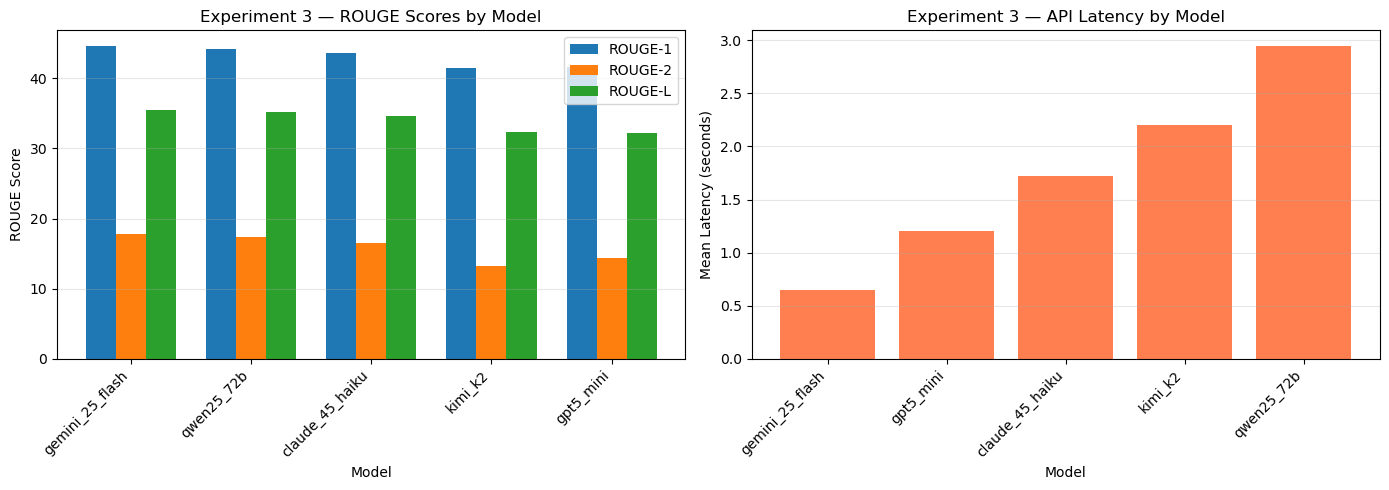

In [31]:
import matplotlib.pyplot as plt

if rouge_df is not None and len(rouge_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # ROUGE scores bar chart (matching style of Experiments 1 & 2)
    ax = axes[0]
    models = rouge_df.index.tolist()
    x = np.arange(len(models))
    width = 0.25
    
    r1 = rouge_df["rouge1"].tolist()
    r2 = rouge_df["rouge2"].tolist()
    rL = rouge_df["rougeL"].tolist()
    
    ax.bar(x - width, r1, width, label="ROUGE-1")
    ax.bar(x, r2, width, label="ROUGE-2")
    ax.bar(x + width, rL, width, label="ROUGE-L")
    
    ax.set_xlabel("Model")
    ax.set_ylabel("ROUGE Score")
    ax.set_title("Experiment 3 — ROUGE Scores by Model")
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha="right")
    ax.legend()
    ax.grid(True, alpha=0.3, axis="y")
    
    # Latency bar chart
    ax = axes[1]
    if latency_df is not None and len(latency_df) > 0:
        latency_models = latency_df.index.tolist()
        latency_means = latency_df["mean"].tolist()
        x_lat = np.arange(len(latency_models))
        
        ax.bar(x_lat, latency_means, color="coral")
        ax.set_xlabel("Model")
        ax.set_ylabel("Mean Latency (seconds)")
        ax.set_title("Experiment 3 — API Latency by Model")
        ax.set_xticks(x_lat)
        ax.set_xticklabels(latency_models, rotation=45, ha="right")
        ax.grid(True, alpha=0.3, axis="y")
    else:
        ax.text(0.5, 0.5, "No latency data", ha="center", va="center", transform=ax.transAxes)
        ax.set_title("API Latency by Model")
    
    plt.tight_layout()
    
    # Save figure
    fig_path = OUTPUT_DIR / "rouge_latency_comparison.png"
    plt.savefig(fig_path, dpi=150, bbox_inches="tight")
    print(f"Saved figure to: {fig_path}")
    
    plt.show()

else:
    print("No data to visualize.")

## 11. Test Set Qualitative Examples

Examine sample outputs from each model to understand quality beyond ROUGE scores.

ROUGE measures n-gram overlap but can't capture:
- **Semantic accuracy:** Does the summary mean the right thing?
- **Fluency:** Does it read naturally?
- **Completeness:** Are key details included?
- **Hallucination:** Does it invent information?

Manual inspection of representative examples helps identify these patterns.

In [32]:
def show_qualitative_examples(df, model_label, n=5, max_dialogue_chars=300, seed=42):
    """
    Display qualitative examples for a single model.
    
    Shows dialogue, human reference, and model prediction side by side.
    Matches the format used in Experiments 1 & 2.
    """
    # Filter out errors
    valid_df = df[~df["model_summary"].str.startswith(ERROR_PREFIX)]
    
    if len(valid_df) == 0:
        print(f"No valid examples for {model_label}")
        return
    
    # Sample examples
    sample = valid_df.sample(n=min(n, len(valid_df)), random_state=seed)
    
    print(f"--- {n} qualitative samples (seed={seed}) ---")
    
    for i, (idx, row) in enumerate(sample.iterrows()):
        dialogue = row["dialogue"]
        if len(dialogue) > max_dialogue_chars:
            dialogue = dialogue[:max_dialogue_chars] + " ..."
        
        print(f"ID {idx}")
        print(f"DIALOGUE: {dialogue}")
        print(f"HUMAN: {row['reference_summary']}")
        # Pad model output to fixed width for alignment
        model_summary = row['model_summary']
        print(f"MODEL: {model_summary:<100}")
        print("-" * 80)


# Show examples for each model
for label in results_by_model:
    print(f"\n{'='*60}")
    print(f"TEST SET: Qualitative Examples — {label}")
    print(f"{'='*60}")
    show_qualitative_examples(results_by_model[label], label, n=5, seed=SEED)


TEST SET: Qualitative Examples — gpt5_mini
--- 5 qualitative samples (seed=42) ---
ID 86
DIALOGUE: Olafur: are we doing anything for New Year's Eve?
Nathalie: I was thinking about something classy, like opera or sth like that
Zoe: how much does it cost?
Olafur: opera is not for me
Nathalie: so what do you propose?
Nathalie: it's 100$ 
Olafur: I was thinking about partying somewhere
Nathalie: part ...
HUMAN: Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho.
MODEL: They decide against opera and agree to a classy New Year’s Eve party at a Soho club (Breakfast at Tiffany’s theme), and plan to buy tickets soon.
--------------------------------------------------------------------------------
ID 432
DIALOGUE: Javier: Hey do you know any tattoo parlors over here with English speaking employees?
Judie: Oh there's Warsaw ink
Javier: the name sounds neat... have you ha

## 12. Side-by-Side Model Comparison

Compare how different models summarize the same dialogues.

This reveals stylistic differences that ROUGE scores obscure:
- Some models are more concise, others more elaborate
- Some focus on outcomes, others on process
- Some add interpretive framing, others stay strictly factual

Seeing the same dialogue processed by all five models makes these patterns visible.

In [33]:
print("\n" + "=" * 70)
print("SIDE-BY-SIDE MODEL COMPARISON")
print("=" * 70)

if len(results_by_model) < 2:
    print("Need at least 2 models for comparison.")
else:
    # Find dialogues common to all models
    dialogue_sets = {
        label: set(df["dialogue"].tolist())
        for label, df in results_by_model.items()
    }
    
    common_dialogues = set.intersection(*dialogue_sets.values())
    
    if len(common_dialogues) == 0:
        print("No common dialogues across all models.")
    else:
        print(f"Found {len(common_dialogues)} dialogues common to all {len(results_by_model)} models.")
        
        # Sample a few for comparison
        n_compare = min(3, len(common_dialogues))
        common_list = list(common_dialogues)
        
        rng = np.random.default_rng(SEED)
        sample_indices = rng.choice(len(common_list), size=n_compare, replace=False)
        sample_dialogues = [common_list[i] for i in sample_indices]
        
        # Get reference from first model's data
        first_model = list(results_by_model.keys())[0]
        first_df = results_by_model[first_model]
        
        for i, dialogue in enumerate(sample_dialogues, 1):
            ref_row = first_df[first_df["dialogue"] == dialogue].iloc[0]
            reference = ref_row["reference_summary"]
            
            print(f"\n{'='*70}")
            print(f"COMPARISON EXAMPLE {i}")
            print(f"{'='*70}")
            
            # Truncate long dialogues
            display_dialogue = dialogue[:400] + "..." if len(dialogue) > 400 else dialogue
            print(f"\n[DIALOGUE]\n{display_dialogue}")
            print(f"\n[HUMAN SUMMARY]\n{reference}")
            print(f"\n[MODEL SUMMARIES]")
            
            for label, df in results_by_model.items():
                match = df[df["dialogue"] == dialogue]
                if len(match) > 0:
                    summary = match.iloc[0]["model_summary"]
                    # Truncate long summaries
                    if len(summary) > 150:
                        summary = summary[:150] + "..."
                    print(f"  {label:20s}: {summary}")
                else:
                    print(f"  {label:20s}: [NOT FOUND]")
            
            print("-" * 70)


SIDE-BY-SIDE MODEL COMPARISON
Found 819 dialogues common to all 5 models.

COMPARISON EXAMPLE 1

[DIALOGUE]
Ryan: I have a bad feeling about this
Ryan: <file_other>
Sebastian: Ukraine...
Sebastian: This russian circus will never end...
Ryan: I hope the leaders of of nations will react somehow to this shit.
Sebastian: I hope so too :(

[HUMAN SUMMARY]
Ryan and Sebastian are worried about the political situation in Ukraine.

[MODEL SUMMARIES]
  gpt5_mini           : Ryan and Sebastian express concern and frustration about Russia’s actions in Ukraine, hoping international leaders will respond.
  gemini_25_flash     : Ryan and Sebastian are concerned about the ongoing conflict in Ukraine, hoping for international intervention to resolve the situation.
  claude_45_haiku     : Ryan and Sebastian express concern about the situation in Ukraine and hope that world leaders will respond to the ongoing Russian conflict.
  qwen25_72b          : Ryan and Sebastian express concern about the situatio

## 13. Save Test Results

Save final results for comparison with Experiments 1 and 2.

In [34]:
print("\n" + "=" * 70)
print("SAVING RESULTS")
print("=" * 70)

# Save ROUGE summary
if rouge_df is not None:
    rouge_summary_path = OUTPUT_DIR / "rouge_summary.csv"
    rouge_df.to_csv(rouge_summary_path)
    print(f"\n✓ Saved ROUGE summary to: {rouge_summary_path}")

# Save latency summary
if latency_df is not None:
    latency_summary_path = OUTPUT_DIR / "latency_summary.csv"
    latency_df.to_csv(latency_summary_path)
    print(f"✓ Saved latency summary to: {latency_summary_path}")

# Save combined test results (for notebook 05 comparison)
# Format matches Experiments 1 & 2 exactly
if rouge_df is not None:
    test_results_data = []
    
    for model in rouge_df.index:
        row = {
            "model": model,
            "test_loss": np.nan,  # N/A for API models
            "rouge1": rouge_df.loc[model, "rouge1"],  # Already in percentage
            "rouge2": rouge_df.loc[model, "rouge2"],
            "rougeL": rouge_df.loc[model, "rougeL"],
            "rougeLsum": rouge_df.loc[model, "rougeLsum"],
        }
        test_results_data.append(row)
    
    test_results_df = pd.DataFrame(test_results_data)
    test_results_df.to_csv(TEST_RESULTS_PATH, index=False)
    print(f"✓ Saved test results to: {TEST_RESULTS_PATH}")
    
    print("\nTest Results (for comparison with Experiments 1 & 2):")
    display(test_results_df)

# Save predictions for each model
print(f"\n✓ Predictions saved to: {PREDICTIONS_DIR}")
for label, df in results_by_model.items():
    # Rename columns to match Experiments 1 & 2 format
    pred_df = df.rename(columns={
        "reference_summary": "summary",
        "model_summary": "model_prediction",
    })
    pred_path = PREDICTIONS_DIR / f"{label}_test_predictions.csv"
    pred_df.to_csv(pred_path, index=False)
    print(f"  - {pred_path.name}")

# Save evaluation metadata
eval_metadata = {
    "evaluation_mode": EVALUATION_MODE,
    "n_samples": len(eval_df),
    "seed": SEED,
    "max_target_len": MAX_TARGET_LEN,
    "temperature": TEMPERATURE,
    "models_evaluated": list(results_by_model.keys()),
    "timestamp": pd.Timestamp.now().isoformat(),
}

metadata_path = OUTPUT_DIR / "evaluation_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(eval_metadata, f, indent=2)
print(f"\n✓ Saved evaluation metadata to: {metadata_path}")


SAVING RESULTS

✓ Saved ROUGE summary to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/rouge_summary.csv
✓ Saved latency summary to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/latency_summary.csv
✓ Saved test results to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/test_results.csv

Test Results (for comparison with Experiments 1 & 2):


,model,test_loss,rouge1,rouge2,rougeL,rougeLsum
0,gemini_25_flash,NaN,44.60,17.85,35.49,35.51
1,qwen25_72b,NaN,44.15,17.31,35.17,35.19
2,claude_45_haiku,NaN,43.62,16.55,34.58,34.59
3,kimi_k2,NaN,41.42,13.22,32.36,32.38
4,gpt5_mini,NaN,41.56,14.34,32.15,32.17



✓ Predictions saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/predictions
  - gpt5_mini_test_predictions.csv
  - gemini_25_flash_test_predictions.csv
  - claude_45_haiku_test_predictions.csv
  - qwen25_72b_test_predictions.csv
  - kimi_k2_test_predictions.csv

✓ Saved evaluation metadata to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier/evaluation_metadata.json


## 14. Final Summary

In [35]:
print("\n" + "=" * 70)
print("EXPERIMENT 3 — FINAL SUMMARY")
print("=" * 70)

print(f"\nEvaluation Configuration:")
print(f"  Mode: {EVALUATION_MODE}")
print(f"  Test samples: {len(eval_df)}")
print(f"  Models evaluated: {len(results_by_model)}")

print(f"\nGeneration Parameters:")
print(f"  Max target length: {MAX_TARGET_LEN} (aligned with Experiments 1 & 2)")
print(f"  Temperature: {TEMPERATURE}")

if rouge_df is not None and len(rouge_df) > 0:
    print(f"\nTest Set Performance (sorted by ROUGE-L):")
    
    for model in rouge_df.index:
        r1 = rouge_df.loc[model, "rouge1"]
        r2 = rouge_df.loc[model, "rouge2"]
        rL = rouge_df.loc[model, "rougeL"]
        n = rouge_df.loc[model, "n_samples"]
        
        print(f"\n  {model}:")
        print(f"    ROUGE-1: {r1:.2f}")
        print(f"    ROUGE-2: {r2:.2f}")
        print(f"    ROUGE-L: {rL:.2f}")
        print(f"    (n={int(n)} samples)")
    
    # Best model
    best_model = rouge_df.index[0]  # Already sorted by rougeL descending
    best_rougeL = rouge_df.loc[best_model, "rougeL"]
    
    print(f"\n  Best Model: {best_model} (ROUGE-L: {best_rougeL:.2f})")

if latency_df is not None and len(latency_df) > 0:
    fastest = latency_df["mean"].idxmin()
    fastest_latency = latency_df.loc[fastest, "mean"]
    print(f"\n  Fastest Model: {fastest} (mean: {fastest_latency:.2f}s)")

print(f"\nArtifacts saved to: {OUTPUT_DIR}")
print(f"  - ROUGE summary: rouge_summary.csv")
print(f"  - Latency summary: latency_summary.csv")
print(f"  - Test results: test_results.csv")
print(f"  - Predictions: predictions/")

print("\n" + "=" * 70)


EXPERIMENT 3 — FINAL SUMMARY

Evaluation Configuration:
  Mode: full
  Test samples: 819
  Models evaluated: 5

Generation Parameters:
  Max target length: 64 (aligned with Experiments 1 & 2)
  Temperature: 0.2

Test Set Performance (sorted by ROUGE-L):

  gemini_25_flash:
    ROUGE-1: 44.60
    ROUGE-2: 17.85
    ROUGE-L: 35.49
    (n=819 samples)

  qwen25_72b:
    ROUGE-1: 44.15
    ROUGE-2: 17.31
    ROUGE-L: 35.17
    (n=789 samples)

  claude_45_haiku:
    ROUGE-1: 43.62
    ROUGE-2: 16.55
    ROUGE-L: 34.58
    (n=819 samples)

  kimi_k2:
    ROUGE-1: 41.42
    ROUGE-2: 13.22
    ROUGE-L: 32.36
    (n=819 samples)

  gpt5_mini:
    ROUGE-1: 41.56
    ROUGE-2: 14.34
    ROUGE-L: 32.15
    (n=819 samples)

  Best Model: gemini_25_flash (ROUGE-L: 35.49)

  Fastest Model: gemini_25_flash (mean: 0.65s)

Artifacts saved to: /home/timnevits/projects/flatiron-language-models-for-ai/models/api-frontier
  - ROUGE summary: rouge_summary.csv
  - Latency summary: latency_summary.csv
  - Tes

## 15. Key Takeaways

### The Surprise: Fine-Tuned Local Models Win on ROUGE

The most striking finding from this experiment is that **zero-shot frontier models underperform our fine-tuned local baselines** on automatic metrics:

| Model | ROUGE-1 | ROUGE-2 | ROUGE-L | Type |
|-------|---------|---------|---------|------|
| **BART (Exp 2)** | **50.27** | **25.71** | **42.13** | Fine-tuned local |
| T5 (Exp 2) | 47.43 | 22.92 | 39.08 | Fine-tuned local |
| Gemini 2.5 Flash | 44.60 | 17.85 | 35.49 | Zero-shot API |
| Qwen 2.5 72B | 44.15 | 17.31 | 35.17 | Zero-shot API |
| Claude 4.5 Haiku | 43.62 | 16.55 | 34.58 | Zero-shot API |
| DistilBERT→GPT2 (Exp 1) | 37.73 | 14.26 | 30.29 | Fine-tuned local |
| Kimi K2 | 41.42 | 13.22 | 32.36 | Zero-shot API |
| GPT-5 Mini | 41.56 | 14.34 | 32.15 | Zero-shot API |

**Key observation:** The best frontier model (Gemini 2.5 Flash at ROUGE-L 35.49) falls **6.64 points below** fine-tuned BART (42.13). Even our "Frankenstein" DistilBERT→DistilGPT2 model from Experiment 1 is competitive with GPT-5 Mini and Kimi K2.

**Why does this happen?** 

Zero-shot models optimize for *general helpfulness*, not SAMSum-style summaries specifically. They tend to:
- Write longer, more elaborate summaries than SAMSum's terse 15–30 word references
- Include contextual framing ("The group decided...", "After discussion...")
- Occasionally add interpretive commentary

Fine-tuned models, by contrast, learn exactly what SAMSum annotators considered a "good" summary—matching their length, style, and focus on outcomes over process.

---

### Price vs. Performance: No Clear Winner

One might expect that more expensive models produce better summaries. The data tells a different story:

| Model | Input Cost | Output Cost | ROUGE-L | Rank |
|-------|------------|-------------|---------|------|
| **Qwen 2.5 72B** | **$0.07/M** | **$0.26/M** | **35.17** | **2nd** |
| GPT-5 Mini | $0.25/M | $2.00/M | 32.15 | 5th |
| Gemini 2.5 Flash | $0.30/M | $2.50/M | 35.49 | 1st |
| Kimi K2 | $0.39/M | $1.90/M | 32.36 | 4th |
| Claude 4.5 Haiku | $1.00/M | $5.00/M | 34.58 | 3rd |

**Key observations:**
- **Qwen 2.5 72B** is the **cheapest** model ($0.07/M input) yet ranks **2nd** on ROUGE-L
- **Claude 4.5 Haiku** is the **most expensive** (14× Qwen's input cost) yet ranks only **3rd**
- **Gemini 2.5 Flash** offers the best ROUGE-L (35.49) at mid-tier pricing

For dialogue summarization specifically, the open-weight Qwen model delivers near-frontier quality at a fraction of the cost. This challenges the assumption that "bigger lab = better results."

---

### Zero-Shot Summary Quality: Good but Verbose

From the qualitative examples, frontier models produce **fluent, accurate summaries** that capture the main points. The issue is style mismatch, not comprehension.

**Example 1 (Test ID 432 — Tattoo Parlor):**

| Source | Summary |
|--------|---------|
| **Human** | "Javier was initially eager to have a tattoo done at Warsaw Ink but the price turned out to be too high. Javier decided to have a tattoo done in Colombia." |
| **BART** | "Javier will get a Warsaw ink tattoo back in colombia." |
| **Gemini** | "Javier asked Judie for English-speaking tattoo parlor recommendations. Judie suggested Warsaw Ink, but Javier decided against it due to the high price." |
| **GPT-5 Mini** | "Javier asks for English-speaking tattoo parlors; Judie recommends Warsaw Ink and says her girlfriend got a tattoo there for $1000, so Javier decides to get tattooed in Colombia instead." |

The frontier models tell the *story* well—GPT-5 Mini even includes the price point ($1000) that explains Javier's decision. But ROUGE penalizes the extra words that don't appear in the reference.

**Example 2 (Test ID 86 — New Year's Eve Planning):**

| Source | Summary |
|--------|---------|
| **Human** | "Nathalie, Olafur and Zoe are planning the New Year's Eve. Nathalie wants something classy. Olafur doesn't like opera. They want to go to the Breakfast at Tiffany's party in Soho." |
| **BART** | "Olafur and Nathalie will go to Tiffany's party for New Year's Eve." |
| **Gemini** | "The group decided to go to a club in Soho for New Year's Eve, after considering opera and a 'Breakfast at Tiffany's' party. They need to buy tickets soon." |
| **Kimi K2** | "Group agrees on a 'classy' New Year's Eve: they'll buy tickets for the Breakfast-at-Tiffany's-themed party at Soho club." |

Notice how BART is concise but drops Zoe entirely. The frontier models capture more context (the opera discussion, the ticket purchase) but use more words doing so. Kimi K2 even preserves the "classy" requirement that was important to Nathalie.

**Example 3 (Test ID 417 — Cancelled Meeting):**

| Source | Summary |
|--------|---------|
| **Human** | "Miranda can't make her meeting with Stephanie as she has to work." |
| **BART** | "Miranda has to work 20 hours a day." |
| **Claude** | "Miranda requests to cancel tomorrow's meeting due to work obligations. Stephanie agrees after Miranda explains her demanding schedule as a young doctor." |
| **Kimi K2** | "Miranda canceled tomorrow's meeting due to work; Stephanie accepted after some teasing about doctors' grueling hours." |

Here BART misses the point entirely—focusing on the "20 hours" detail rather than the meeting cancellation. Claude and Kimi K2 both capture the actual outcome (meeting cancelled, Stephanie agreed) plus the interpersonal dynamic. This is a case where the frontier models genuinely outperform on *semantic accuracy* even if ROUGE doesn't reflect it.

---

### Latency: Faster Than Expected, but Variable

| Model | Mean Latency | P50 | P95 | Max |
|-------|-------------|-----|-----|-----|
| **Gemini 2.5 Flash** | **0.65s** | 0.62s | 0.81s | 2.65s |
| GPT-5 Mini | 1.20s | 1.13s | 1.64s | 5.81s |
| Claude 4.5 Haiku | 1.72s | 1.63s | 2.41s | 11.45s |
| Kimi K2 | 2.20s | 1.18s | 6.34s | 11.42s |
| Qwen 2.5 72B | 2.95s | 2.17s | 8.09s | 14.89s |

**Comparison to local models:**
- BART (Exp 2): 0.20s mean
- T5 (Exp 2): 0.23s mean
- DistilBERT→GPT2 (Exp 1): 0.40s mean

The fastest API model (Gemini 2.5 Flash at 0.65s) is **~3× slower** than fine-tuned BART running locally. For batch processing, this adds up quickly—summarizing 1,000 conversations takes ~11 minutes with Gemini vs ~3 minutes with local BART.

**Latency observations:**
- **Gemini 2.5 Flash** lives up to its "Flash" name—fastest by a wide margin
- **Chinese models (Kimi K2, Qwen)** showed higher variance, likely due to geographic routing from US-based testing
- **Tail latency matters:** P95 values reach 6–8s for some models, which could cause timeouts in production

---

### Reliability: Mostly Solid, One Outlier

Most models completed all 819 test examples without errors. The exception:

- **Qwen 2.5 72B:** 30 errors (3.7% failure rate)

These failures were API timeouts or malformed responses, not content issues. Despite its low cost and strong ROUGE scores, Qwen's reliability would need monitoring in production. The US-based frontier providers (OpenAI, Google, Anthropic) had zero failures across all test examples.

---

### Cost Projection: The Real Math

For a messaging platform at scale, let's estimate costs for summarizing 1M conversations/month:

**Assumptions:**
- Average dialogue: ~100 words → ~150 tokens input
- Average summary: ~25 words → ~40 tokens output
- 1M conversations/month

| Model | Monthly Input Cost | Monthly Output Cost | **Total/Month** |
|-------|-------------------|--------------------:|----------------:|
| Qwen 2.5 72B | $10.50 | $10.40 | **$20.90** |
| GPT-5 Mini | $37.50 | $80.00 | **$117.50** |
| Gemini 2.5 Flash | $45.00 | $100.00 | **$145.00** |
| Kimi K2 | $58.50 | $76.00 | **$134.50** |
| Claude 4.5 Haiku | $150.00 | $200.00 | **$350.00** |

**vs. Fine-tuned local model:**
- One-time training cost: ~$10–50 in GPU time
- Inference: Free (your own hardware)
- Monthly cost at scale: **~$0** (just electricity)

At 1M conversations/month, even the cheapest API model (Qwen) costs ~$250/year. Claude would cost ~$4,200/year. Fine-tuned BART costs essentially nothing after the initial training investment.

---

### The Real Trade-off

This experiment reveals that the choice between fine-tuned local models and frontier APIs isn't primarily about quality—it's about operational trade-offs:

| Factor | Fine-Tuned Local | Zero-Shot API |
|--------|-----------------|---------------|
| **ROUGE scores** | Higher (style-matched) | Lower (verbose) |
| **Summary fluency** | Good | Excellent |
| **Semantic accuracy** | Sometimes misses nuance | Often more complete |
| **Latency** | 0.2–0.4s | 0.6–3.0s |
| **Cost at 1M/month** | ~$0 | $21–350 |
| **Privacy** | Data stays local | Data leaves infra |
| **Setup effort** | Hours of training | Minutes of prompting |
| **Customization** | Full control | Prompt engineering only |
| **Reliability** | Deterministic | Provider-dependent |

For a quick prototype or low-volume use case, API models are the obvious choice—especially Qwen at $0.07/M input. For production at scale with specific style requirements, fine-tuning wins decisively.

---

### What's Next

The final comparison notebook will:
- Consolidate all ROUGE and latency metrics into unified tables
- Analyze error patterns across all three experiments
- Discuss deployment trade-offs in more depth
- Provide final recommendations for the "Acme Communications" use case

For now, the key insight is clear: **fine-tuning matters for metrics, but zero-shot models aren't wrong—they're just different.** Even relatively small models (BART at 139M parameters, T5 at 60M) can outperform frontier giants on ROUGE when properly trained. But as the qualitative examples show, ROUGE doesn't tell the whole story. Sometimes the verbose, context-rich frontier summary is actually *better*—it just doesn't match the reference annotator's style.

The "just use GPT" approach is convenient, but it's not a free lunch—and for this task, the lunch you get depends heavily on how you measure "good."
